In [24]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb

# Model

Now we will try to use an ensemble learner using all 3 methods utilized so far: Logistic Regression, Random Forests, and XGboost. We will use soft voting (averaging over all the predicted probabilities) to classify the players

In [25]:
# Load and filter data
nba_train = pd.read_csv('Data_Scripting_Cleaning/Full_data/Training_Sets/nba_train.csv')
nba_test = pd.read_csv('Data_Scripting_Cleaning/Full_data/Test_Sets/nba_test.csv')

min_minutes = nba_train[(nba_train['all_nba_c_year']==1)].MP.min()
min_G = nba_train[(nba_train['all_nba_c_year']==1)].G.min()
nba_filt_train = nba_train[(nba_train['MP']>=min_minutes) & (nba_train['G']>=min_G)]
nba_filt_test = nba_test[(nba_test['MP']>=min_minutes) & (nba_test['G']>=min_G)]

y_train = nba_filt_train['all_nba_c_year']

y_test = nba_filt_test['all_nba_c_year']

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

num_features = ['Age','G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'W',
       'num_all_nba']

cat_features = ['Tm']

#Now we will fit a random forest model to the data. We will fit this data into a pipeline to scale the data and then fit the model.

preprocessor = ColumnTransformer(
    [("select", "passthrough", num_features),
     ("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features)],
     remainder="drop"
)

X_train = preprocessor.fit_transform(nba_filt_train)
X_test = preprocessor.transform(nba_filt_test)


In [35]:

clf1 = LogisticRegression(random_state=1, C = 0.20433597178569418,
                          penalty = 'l1', solver = 'liblinear',
                          max_iter = 10000,
                          class_weight = 'balanced')
clf2 = RandomForestClassifier(random_state=1,
                              n_estimators=100,
                              min_samples_split=25,
                              min_samples_leaf=2,
                              max_features=0.2,
                              max_depth=25,
                              class_weight='balanced'
                              )
scale_pos = (len(y_train) - sum(y_train))/sum(y_train)
clf3 = xgb.XGBClassifier(random_state=1,
                            n_estimators=200,
                            min_child_weight=2,
                            max_depth=20,
                            learning_rate=0.1,
                            gamma=0.3,
                            colsample_bytree=0.6,
                            subsample=1,
                            scale_pos_weight=scale_pos
                            )

ensemb_clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)],
                              voting='soft', weights=[1,1,1])


In [36]:
ensemb_clf.fit(X_train, y_train)
y_pred = ensemb_clf.predict(X_test)
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Results

We have the following metrics for this ensemble learner:

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       819
           1       0.74      0.86      0.79       123

    accuracy                           0.94       942
   macro avg       0.86      0.91      0.88       942
weighted avg       0.95      0.94      0.94       942



We see that we end up with similar precision, recall as our logistic regression, indicating we did not do that much better than the individual models

For our confusion matrix we have:

In [38]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,781,38,819
1,17,106,123
All,798,144,942


We may also consider the ROC AUC curves of all the models:

Logistic Regression AUC:  0.9749446578714871
Random Forest AUC:  0.9745872916604624
XGBoost AUC:  0.9754608535096341
Ensemble AUC:  0.9783793442330028


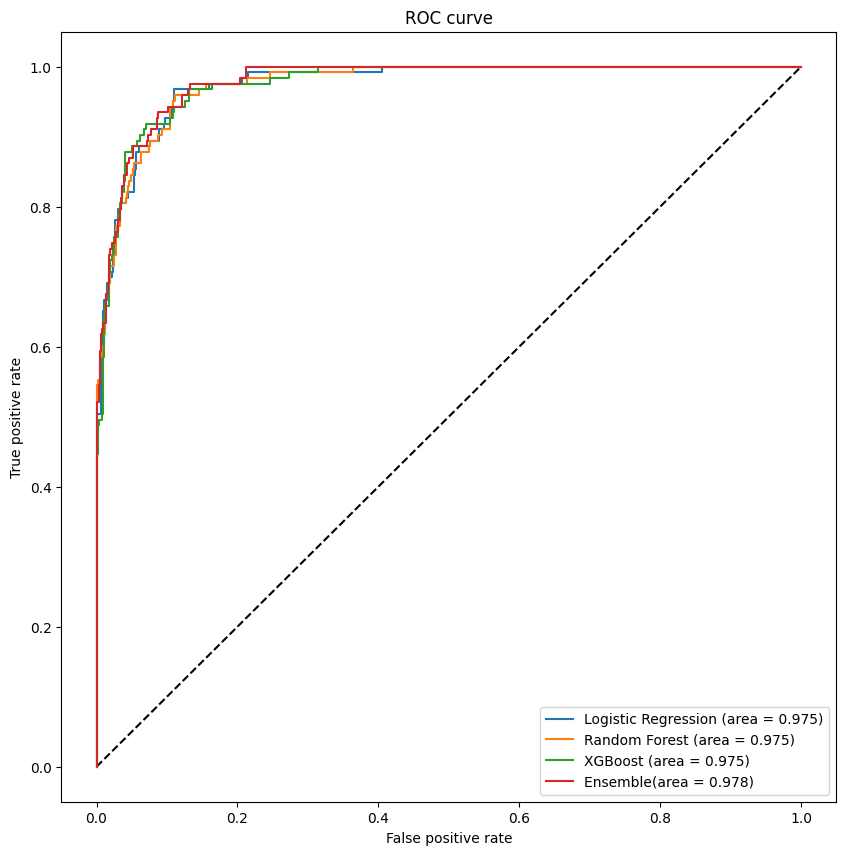

In [39]:
#Now we can draw the ROC curves for all 3 models and the ensemble model.
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#Now we may plot them,
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(*roc_curve(y_test, clf1.predict_proba(X_test)[:,1])[:2], label="Logistic Regression (area = %0.3f)" % auc(*roc_curve(y_test, clf1.predict_proba(X_test)[:,1])[:2]))
plt.plot(*roc_curve(y_test, clf2.predict_proba(X_test)[:,1])[:2], label="Random Forest (area = %0.3f)" % auc(*roc_curve(y_test, clf2.predict_proba(X_test)[:,1])[:2]))
plt.plot(*roc_curve(y_test, clf3.predict_proba(X_test)[:,1])[:2], label="XGBoost (area = %0.3f)" % auc(*roc_curve(y_test, clf3.predict_proba(X_test)[:,1])[:2]))
plt.plot(*roc_curve(y_test, ensemb_clf.predict_proba(X_test)[:,1])[:2], label="Ensemble(area = %0.3f)" % auc(*roc_curve(y_test, ensemb_clf.predict_proba(X_test)[:,1])[:2]))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')


print("Logistic Regression AUC: ", auc(*roc_curve(y_test, clf1.predict_proba(X_test)[:,1])[:2]))
print("Random Forest AUC: ", auc(*roc_curve(y_test, clf2.predict_proba(X_test)[:,1])[:2]))
print("XGBoost AUC: ", auc(*roc_curve(y_test, clf3.predict_proba(X_test)[:,1])[:2]))
print("Ensemble AUC: ", auc(*roc_curve(y_test, ensemb_clf.predict_proba(X_test)[:,1])[:2]))

Now we may put all our results into a dataframe

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#Putting precision and recall and ROC-AUC score into a dataframe for all 4 models
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble']
precision = [0,0,0,0]
recall = [0,0,0,0]
roc_auc = [0,0,0,0]
f1_scores = [0,0,0,0]
accuracy = [0,0,0,0]
for i, model in enumerate([clf1, clf2, clf3, ensemb_clf]):
    precision[i] = precision_score(y_test, model.predict(X_test))
    recall[i] = recall_score(y_test, model.predict(X_test))
    roc_auc[i] = auc(*roc_curve(y_test, model.predict_proba(X_test)[:,1])[:2])
    f1_scores[i] = f1_score(y_test, model.predict(X_test))
    accuracy[i] = accuracy_score(y_test, model.predict(X_test))
res_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F-1 Score':f1_scores ,'ROC-AUC': roc_auc})
res_df.to_csv('results.csv', index=False)

In [41]:
res_df

,Model,Accuracy,Precision,Recall,F-1 Score,ROC-AUC
0,Logistic Regression,0.905520,0.588542,0.918699,0.717460,0.974945
1,Random Forest,0.937367,0.725352,0.837398,0.777358,0.974587
2,XGBoost,0.943737,0.761194,0.829268,0.793774,0.975461
3,Ensemble,0.941614,0.736111,0.861789,0.794007,0.978379


In [42]:
y_test.value_counts(normalize=True)

0    0.869427
1    0.130573
Name: all_nba_c_year, dtype: float64